# Distance vs Duration

## Retrieve dataset

In [31]:
import os
import logging
import pandas as pd
import numpy as np
import glob

BASIC_PATH = '../Data/'
ALL_FILES = BASIC_PATH + '*.csv'

def readOneFile(url):
    return pd.read_csv(url, index_col = 0)

data = readOneFile(BASIC_PATH + "flights_2010_9.csv")
print("Aantal records om te beginnen:", len(data))
data = pd.DataFrame(data=data, columns=["airline", "date", "departure_schedule", "arrival_schedule", "distance", "duration", "speed", "departure_airport", "arrival_airport", "arrival_state", "departure_state"])

Aantal records om te beginnen: 1000000


## Convert military time to datetime

In [32]:
import math
from datetime import datetime

def getTotalMinutes(time):
    time_str = str(time).rjust(4, "0")
    hours = time_str[:-2]
    hours = int(hours)
    if hours == 24:
        hours = 0
    minutes = int(time_str[-2:])
    return datetime(2010, 1, 1, hours, minutes, 0)

data["departure_schedule"] = data["departure_schedule"].map(getTotalMinutes)
data["arrival_schedule"] = data["arrival_schedule"].map(getTotalMinutes)

## Add timezones

In [33]:
# UTC offset by state
timezones = {
    "AL" :-6,
    "AK" :-9,
    "AZ" :-7,
    "AR" :-6,
    "CA" :-8,
    "CO" :-7,
    "CT" :-5,
    "DE" :-5,
    "FL" :-5,
    "GA" :-5,
    "HI" :-10,
    "ID" :-7,
    "IL" :-6,
    "IN" :-5,
    "IA" : -6,
    "KS" : -6,
    "KY" : -6,
    "LA" : -6,
    "ME" : -5,
    "MD" : -5,
    "MA" : -5,
    "MI" : -5,
    "MN" : -6,
    "MS" : -6,
    "MO" : -6,
    "MT" : -7,
    "NE" : -6,
    "NV" : -8,
    "NH" : -5,
    "NJ" : -5,
    "NM" : -7,
    "NY" : -5,
    "NC" : -5,
    "ND" : -6,
    "OH" : -5,
    "OK" : -6,
    "OR" : -8,
    "PA" : -5,
    "RI" : -5,
    "SC" : -5,
    "SD" : -6,
    "TN" : -6,
    "UT": -7,
    "TX": -6,
    "VT": -5,
    "VA": -5,
    "WA": -8,
    "DC": -5,
    "WV": -5,
    "WI": -6,
    "WY": -5
}
data['arrival_tz'] = data['arrival_state'].map(lambda state: timezones[state])
data['departure_tz'] = data['departure_state'].map(lambda state: timezones[state])

## Change local time to UTC

In [34]:
from datetime import timedelta

arrival_schedules = []
departure_schedules = []

def timeToUTC(schedule, tz):
    tdelta = timedelta(hours=abs(tz))
    if tz > 0:
        schedule -= tdelta
    else:
        schedule += tdelta
    return schedule

for i, row in data.iterrows():
    arrival_schedule = row["arrival_schedule"]
    arrival_tz = row["arrival_tz"]
    departure_schedule = row["departure_schedule"]
    departure_tz = row["departure_tz"]
    
    arrival_schedules.append(timeToUTC(arrival_schedule, arrival_tz))
    departure_schedules.append(timeToUTC(departure_schedule, departure_tz))

data["arrival_schedule"] = arrival_schedules
data["departure_schedule"] = departure_schedules

## Calculate duration

In [36]:
durations = []
for i, row in data.iterrows():
    arrival = row["arrival_schedule"]
    departure = row["departure_schedule"]
    if arrival <= departure:
        arrival += timedelta(days=1)
    durations.append(arrival - departure)

data["duration"] = durations

## Calculate speed

In [37]:
speeds = []
for i, row in data.iterrows():
    duration = row["duration"]
    speed = row["distance"] / ((duration.total_seconds() / 60) / 60)
    speeds.append(speed)

data["speed"] = speeds

## Cleanup

In [38]:
filtered_data = data

shortest_distance_in_us = 100 #KM
longest_distance_in_us = 9000 #KM
shortest_duration_in_us = timedelta(minutes=16)
longest_duration_in_us = timedelta(hours=11, minutes=40)

filtered_data = filtered_data[filtered_data.distance.between(shortest_distance_in_us, longest_distance_in_us)]
filtered_data = filtered_data[filtered_data.duration.between(shortest_duration_in_us,longest_duration_in_us)]
print(len(filtered_data))

991082


## Plot

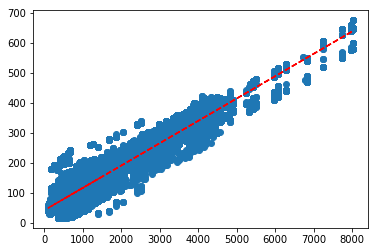

In [42]:
import matplotlib.pyplot as plt

plot_data = filtered_data

x = plot_data['distance']
y = plot_data['duration'].map(lambda tdelta: tdelta.total_seconds() / 60)
plt.scatter(x, y)

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")

plt.show()